In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d
from scipy.optimize import root
import importlib
import classy

from classy import Class


In [2]:
common_settings = {
'omega_b':0.0223828,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
}

In [3]:
chiCDM = Class()
chiCDM.set(common_settings)
aNR= 0.01
chiCDM.set({
'N_ur': 3.046,
'omega_cdm':0.10 ,
'omega_chi':0.02 ,
'acs_chi':aNR,
'cs2_peak_chi':1.
})

chiCDM.compute()
#get the growth factor of a LCDM equivalent
pureCDM = Class()
pureCDM.set(common_settings)
pureCDM.set({
    'N_ur': 3.046,
    'omega_cdm':0.12,
})
pureCDM.compute()


Running CLASS version v3.2.5
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.774286 Gyr
 -> conformal age = 14224.808923 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 2924.241395
    corresponding to conformal time = 131.260128 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.217477        , omega = 0.1            
-> Dark Matter with sound speed (ULAs version): Omega = 0.0434953       , omega = 0.02           
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.72044e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.69026         , omega = 0.317395       
 

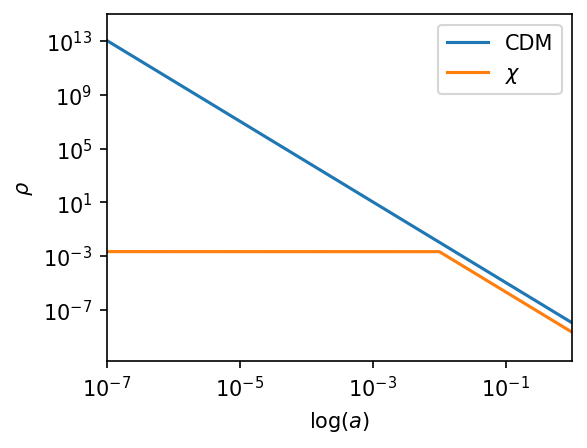

In [4]:
plt.figure(figsize=(4,3), dpi=150)

chibck = chiCDM.get_background() # load background table
a = 1/(chibck['z']+1) # read redshift
rho_cdm=chibck['(.)rho_cdm']
rho_chi=chibck['(.)rho_chi']
rho_crit=chibck['(.)rho_crit']

plt.xlabel(r'$a $')
plt.loglog(a,rho_cdm,label=r'CDM')
plt.loglog(a,rho_chi,label=r'$\chi$')
plt.xlim([1.e-7,1])
plt.ylim([None,1.e15])
plt.legend(loc='best')
plt.xscale('log')
plt.xlabel(r'$\log(a)$')
plt.ylabel(r'$\rho$')
plt.show()


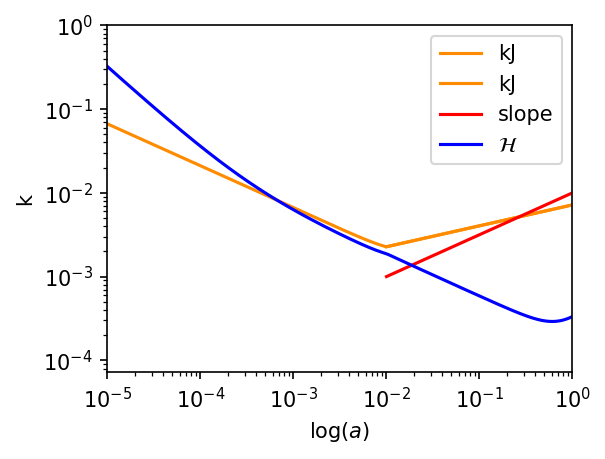

In [6]:
plt.figure(figsize=(4,3), dpi=150)
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc
kJ_chi=chibck['(.)kJ_chi']

Ha=a*chibck['H [1/Mpc]']
Ha_chi_int=interp1d(a,Ha)

plt.xlabel(r'$a $')

plt.loglog(a[a>aNR],kJ_chi[a>aNR],'darkorange',label=r'kJ')
plt.loglog(a,kJ_chi,'darkorange',label=r'kJ')

plt.loglog(a[a>aNR],1.e-3*(a[a>aNR]/aNR)**(0.5),'r',label=r'slope')

plt.loglog(a,Ha/h,'blue',label=r'$\mathcal{H}$')

plt.xlim([1.e-5,1.])
plt.ylim([None,1.])

plt.legend(loc='best')
plt.xscale('log')
plt.xlabel(r'$\log(a)$')
plt.ylabel(r'k')
plt.show()


----
now look at the power spectrum

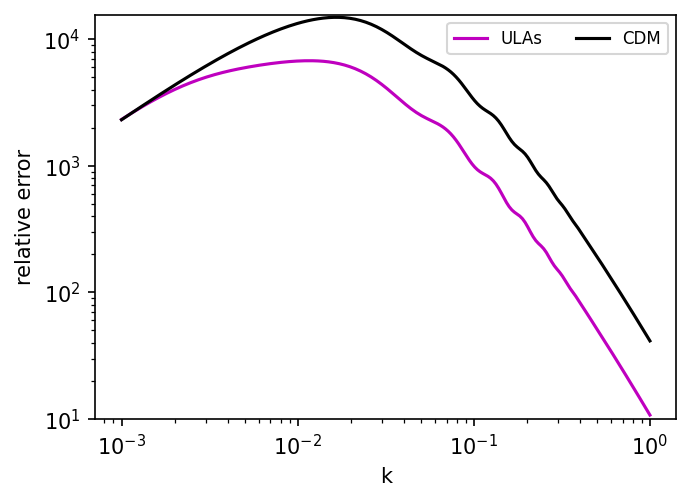

2.3010299956639813 -0.3010299956639812


In [6]:
kk = np.logspace(-3.,0.,200); h = chiCDM.h(); Pk_list=[]
for k in kk:
    Pk_list.append([chiCDM.pk_lin(k*h,0.5)*h**3,pureCDM.pk_lin(k*h,0.5)*h**3]) # function .pk(k,z)
Pk_list=np.array(Pk_list).T

plt.figure(figsize=(5.,3.5), dpi=150)

plt.plot(kk, Pk_list[0],'m', label=f'ULAs')
plt.plot(kk, Pk_list[1], 'k', label=f'CDM')

plt.ylim([10,None])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('relative error')
plt.legend(loc='best', fontsize=8, ncol=2)

plt.show()
print(np.log10(200),np.log10(0.5))